In [30]:
%matplotlib inline
import os
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy.sparse import csr_matrix
import networkx as nx

from scipy.linalg import orthogonal_procrustes

import torch
import torch.optim as optim
from torch_geometric.data import Data

from sklearn.manifold import TSNE
from sklearn.datasets import make_moons  # 导入make_moons函数

from util import Net, GIN, GAT, stationary, reconstruct, dG, GCN
from torch.nn import MSELoss


np.random.seed(0)
torch.manual_seed(0)

n = 2000
m = 500
DISTANCE = 0.1

# 导入moon数据集
x, y = make_moons(n_samples=n, noise=0.1, random_state=0) 
# 分割训练集和测试机
n_train = int(n * 1)
train_ind = torch.randperm(n)[:n_train]
test_ind = torch.LongTensor(list(set(np.arange(n)) - set(train_ind.tolist())))
# K = int(np.sqrt(n) * np.log2(n) / 10) #作为隐藏输入
D = pairwise_distances(x)# 邻接距离矩阵
# 二值化，得到邻接矩阵
A_binary = np.where(D <= DISTANCE, 1, 0)
# A_binary
# 获得所有的边，二元组格式
row_indices, col_indices = np.where(A_binary == 1)
edges = list(zip(row_indices, col_indices))

# 转为tensor
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)
edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
data = Data(x=x, y=y, edge_index=edges)
print(data)


Data(x=[2000, 2], edge_index=[2, 53372], y=[2000])


In [31]:
def get_losses_dG(function: str, num_epoch):
    # 喂到GCN网络中
    function = eval(function)
    net = function(m)
    losses = []
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    net.train()
    for epoch in range(num_epoch):
        ind = torch.eye(n)[:, torch.randperm(n)[:m]]
        # 将节点选择矩阵与特征矩阵连接在一起
        X_extended = torch.hstack([x, ind]) # 
        data = Data(x=X_extended, edge_index=edges)
        rec = net(data) # reconstruct
        loss = dG(x[train_ind], rec[train_ind]) #train loss
        losses.append(loss)
        optimizer.zero_grad() # zero gradient
        loss.backward()
        optimizer.step()
    return losses

def get_losses_MSE(function: str, num_epoch):
    # 喂到GCN网络中
    criterion = MSELoss(reduction='mean')
    function = eval(function)
    net = function(m)
    losses = []
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    net.train()
    for epoch in range(num_epoch):
        ind = torch.eye(n)[:, torch.randperm(n)[:m]]
        # 将节点选择矩阵与特征矩阵连接在一起
        X_extended = torch.hstack([x, ind]) # 
        data = Data(x=X_extended, edge_index=edges)
        rec = net(data) # reconstruct
        loss = criterion(x[train_ind], rec[train_ind]) #train loss
        losses.append(loss)
        optimizer.zero_grad() # zero gradient
        loss.backward()
        optimizer.step()
    return losses

Processing GCN....
Processing GIN....
Processing GAT....


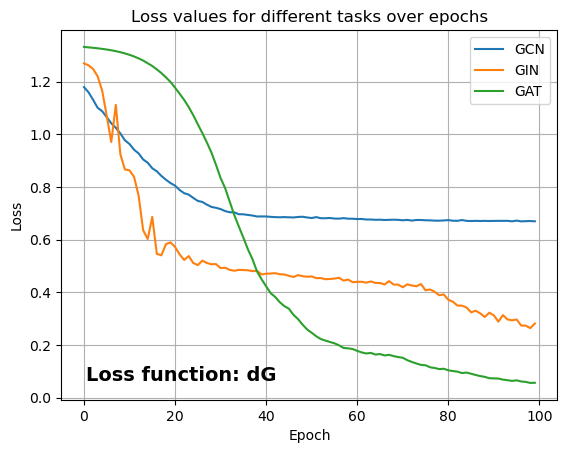

In [32]:
tasks = ["GCN", "GIN", "GAT"]
res = {}
num_epoch = 100
for task in tasks:
    print(f"Processing {task}....")
    res[task] = get_losses_dG(task,num_epoch)

for task in tasks:
    ls = [i.item() for i in res[task]]
    plt.plot(ls, label=task)


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss values for different tasks over epochs')
plt.legend(loc='upper right')
plt.grid(True)
plt.text(0.05, 0.05, 'Loss function: dG', color='black', fontsize=14, weight='bold', transform=plt.gca().transAxes)
plt.savefig('./imgs/losses_dG.jpg')
plt.show()


Processing GCN....
Processing GIN....
Processing GAT....


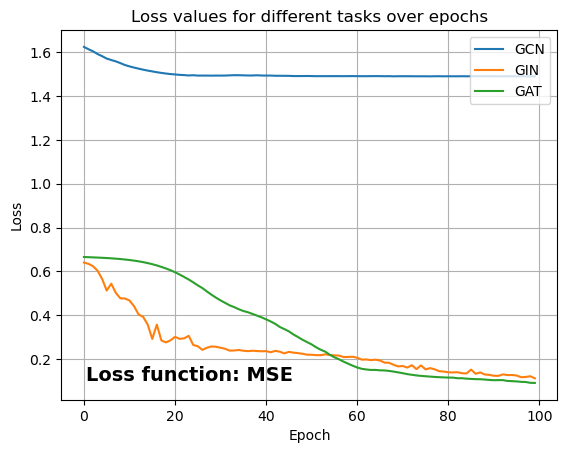

In [33]:
tasks = ["GCN", "GIN", "GAT"]
res = {}
num_epoch = 100
for task in tasks:
    print(f"Processing {task}....")
    res[task] = get_losses_MSE(task,num_epoch)

for task in tasks:
    ls = [i.item() for i in res[task]]
    plt.plot(ls, label=task)


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss values for different tasks over epochs')
plt.legend(loc='upper right')
plt.grid(True)
plt.text(0.05, 0.05, 'Loss function: MSE', color='black', fontsize=14, weight='bold', transform=plt.gca().transAxes)
plt.savefig('./imgs/losses_dG.jpg')
plt.show()